# Project: A/B Test a New Menu Launch (Part3)

### by Sooyeon Won

### Keywords
- Analytical Framework
- A/B tests Design and Analysis  
- A/B Trend & Seasonality Calculation 
- Matching treatment and control units 

## Table of Contents
<ul>
<li><a href="#Intro">Introduction (Part1)</a></li>
<li><a href="#Wrangling">Data Wrangling (Part1)</a></li>
<li><a href="#Exploration">Data Exploration (Part2)</a></li>
<li><a href="#Analysis">Data Analysis (Part3)</a></li>
    - Upload Datasets from the Analysis Part 1 <br>
    - Calculate Traffic Trend (**modified**) <br>
    - Calculate Traffic Seasonality (**modified**) <br>
    - Matching Units<br>
    - Analysis with Visualizations
    
<li><a href="#Conclusion">Conclusion (Part3)</a></li>
</ul>

## Upload Datasets from the Analysis Part 1

In [1]:
# Import the relevant libraries 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Load the provided datasets
traffic_df = pd.read_csv('traffic_df.csv')
weekly_sales_df = pd.read_csv('weekly_sales_df.csv')
stores_df = pd.read_csv('stores_df.csv')

In [3]:
# Merge the traffic and sales datasets
weekly_merged= traffic_df.merge(weekly_sales_df, how= 'inner', 
                                left_on=['StoreID','Week', 'Week_Start', 'Week_End'], 
                                right_on=['StoreID','Week', 'Week_Start', 'Week_End'])

In [4]:
weekly_merged.shape # Glance at the dataset(1): 10,108 datapoints with 7 features.

(10108, 7)

In [5]:
weekly_merged.head() # Glance at the dataset(2)

,StoreID,Week,Week_Start,Week_End,Invoice_Number,Gross_Margin,Sales
0,1508,1,2015-02-06,2015-02-12,183,1429.4390,3124.61
1,1508,2,2015-02-13,2015-02-19,273,2031.2580,4360.54
2,1508,3,2015-02-20,2015-02-26,153,1022.0430,2217.27
3,1508,4,2015-02-27,2015-03-05,210,1372.2495,2996.95
4,1508,5,2015-03-06,2015-03-12,239,1698.8590,3704.73


## Calculate Traffic Trend

> The traffic trend value per unit is calculated based on the description of [A/B Trend tool](https://help.alteryx.com/current/designer/ab-trend-tool) in Alteryx webpage. The performance metric is the invoice count per week which represents weekly foot traffic. We have 12 weeks of periods to calculate the trend. The trend measure is based on period to period percentage changes in the rolling average (taken over a one year period (52 weeks) to control for seasonal effects) in a performance measure of interest. The trend measure for the period-to-period percentage change in the moving average is calculated as the average of multiple periods. 

In [6]:
# Create a dataframe with StoreID, Week number and Invoice Number 
traffic_mean = weekly_merged.groupby(['StoreID','Week'], as_index= False )['Invoice_Number'].mean()

In [7]:
# Calcuate the rolling average taken over 52 weeks (a period of one year in weeks) to control seasonal effects
traffic_mean['Traffic_Trend'] = traffic_mean.groupby('StoreID')['Invoice_Number'].transform(lambda x: x.rolling(window =52).mean())

In [8]:
traffic_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10108 entries, 0 to 10107
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StoreID         10108 non-null  int64  
 1   Week            10108 non-null  int64  
 2   Invoice_Number  10108 non-null  int64  
 3   Traffic_Trend   3325 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 394.8 KB


In [9]:
nontest_traffic  = traffic_mean.query('Week < 65') # Filter the week number before the test periods

In [10]:
nontest_traffic = nontest_traffic.dropna() # Drop the rows with missing values 

In [11]:
nontest_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 51 to 10095
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StoreID         1729 non-null   int64  
 1   Week            1729 non-null   int64  
 2   Invoice_Number  1729 non-null   int64  
 3   Traffic_Trend   1729 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 67.5 KB


In [12]:
# Calculate the percentage changes in the rolling average per each period. 
traffic_trend_pivot = nontest_traffic.pivot(index = 'StoreID', columns= 'Week', values = 'Invoice_Number')
traffic_trend = traffic_trend_pivot.T.pct_change()
traffic_trend = traffic_trend.dropna()

In [13]:
# Aggregate the 12 periods of percentage changes in the rolling average with the mean value. 
trend_value_df = pd.DataFrame(traffic_trend.mean(), columns=['trend'], index = traffic_trend_pivot.index)
trend_value_df

,trend
StoreID,
1508,0.050026
1542,0.043256
1580,0.043588
1630,0.046803
1662,0.027122
...,...
12586,0.031885
12686,0.058825
12736,0.041383


## Calculate Traffic Seasonality

> The same performance measure (i.e. the number of invoice) is used to assess seasonal effects. Calculating seasonality is a little bit tricky. According to the Alteryx webpage, Seasonality is measured by the percentage of the total level of the performance measure of interest in each reporting period to assess seasonal patterns. In our case, the performance measure is the number of invoices and the reporting period is weeks. Thus, the percentage of total sales (over a 52 week period) that fall into each of 52 weeks is used. The measures of the per period percentage of annual invoice counts are dimensionally reduced via principal components analysis (PCA).

> The A/B trend tool of Alteryx is used to create trend and seasonality variables to use as control variables. To do this, Alteryx recommend users to have at least 52 weeks of data, plus the number of weeks the users select in the tool to calculate trend, before the beginning of the test start date. For the project, we are asked to use 12 weeks to calculate trend, so we need 64 weeks of data prior to the test start date. Since the test lasts for 12 weeks. Therefore we need a total 76 weeks of data.

> However, Alteryx webpage does not clearly mention that which of 52 weeks amid the 76 weeks are used for calculating seasonality values. Thus, I decided to use 52 weeks of data prior to the test start date for the seasonality measurement.

In [14]:
# Filter the 52 weeks prior to the test start date.
nontest_df = weekly_merged.query('Week > 12 & Week < 65') 

In [15]:
# Calculate the percentage of total sales that fall into each of 52 weeks.
Traffic_Seasonality_df= (nontest_df.groupby(['StoreID','Week'])['Invoice_Number'].sum()/nontest_df.groupby('StoreID')['Invoice_Number'].sum()*100).reset_index()

In [16]:
Traffic_Seasonality_df.head() # The column Invoice_Number means the percentage of total sales per week per store.

,StoreID,Week,Invoice_Number
0,1508,13,2.329114
1,1508,14,2.187342
2,1508,15,2.065823
3,1508,16,2.308861
4,1508,17,1.265823


In [17]:
Traffic_Seasonality_pivot = Traffic_Seasonality_df.pivot(index = 'StoreID', columns= 'Week', values = 'Invoice_Number')

>  As eariler mentioned, the measures of the per period percentage of annual invoice counts are dimensionally reduced via principal components analysis (PCA). To do so, I scaled the percentage values first.

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # Create a StandardScaler object
Traffic_Seasonality_scaled = sc.fit_transform(Traffic_Seasonality_pivot.values) 

In [19]:
from sklearn.decomposition import PCA
n_components=1
pca = PCA(n_components)
Traffic_Seasonality_pca=pca.fit_transform(Traffic_Seasonality_scaled)

print("Original shape:   ", Traffic_Seasonality_scaled.shape) 
print("Transformed shape:", Traffic_Seasonality_pca.shape) # The number of percentage of annual invoice counts per period is reduced.

Original shape:    (133, 52)
Transformed shape: (133, 1)


In [20]:
ts_pca = pd.DataFrame(Traffic_Seasonality_pca, columns=['seasonality_pca'], index = Traffic_Seasonality_pivot.index)
ts_pca # Calculated seasonality values per store

,seasonality_pca
StoreID,
1508,0.644776
1542,-4.798297
1580,-1.655745
1630,1.485807
1662,2.619123
...,...
12586,-4.348594
12686,1.941303
12736,-3.049105


In [21]:
# Trend and seasonality value per store 
trendtool_df = trend_value_df.merge(ts_pca, left_on='StoreID', right_on='StoreID', how= 'inner')
trendtool_df.head()

,trend,seasonality_pca
StoreID,,
1508,0.050026,0.644776
1542,0.043256,-4.798297
1580,0.043588,-1.655745
1630,0.046803,1.485807
1662,0.027122,2.619123


## Matching Units

> In Alteryx, the [A/B Controls tool](https://help.alteryx.com/current/designer/ab-controls-tool) matches one to ten control units (for this analysis, stores) to each treatment units, based on criteria such as seasonal patterns and growth trends for a key performance indicator (for this analysis, traffic), along with other variables we earlier selected as control variables (for this analysis, Average Monthly Sales, Region). Possible control units are matched to the provided list of treatment units using nearest neighbor methods based on a [kd-tree algorithm](https://en.wikipedia.org/wiki/K-d_tree).

### Control the categorical variable: Region

In [22]:
# Merge the two dataframes 
match_df= trendtool_df.merge(stores_df, how = 'inner', left_on = 'StoreID', right_on = 'StoreID') 

In [23]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   StoreID          143 non-null    int64  
 1   trend            143 non-null    float64
 2   seasonality_pca  143 non-null    float64
 3   Sq_Ft            143 non-null    int64  
 4   AvgMonthSales    143 non-null    int64  
 5   Name             143 non-null    object 
 6   City             143 non-null    object 
 7   State            143 non-null    object 
 8   Region           143 non-null    object 
 9   Group            143 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 12.3+ KB


In [24]:
# Control the variable region. 
Central = match_df.query('Region == "Central"')
West = match_df.query('Region == "West"')

In [25]:
Central.shape, West.shape

((47, 10), (96, 10))

In [26]:
# Seperate the control and treatment units into different dataframe
Central_T = Central.query('Group =="treatment"')
Central_C = Central.query('Group =="control"')
West_T = West.query('Group =="treatment"')
West_C = West.query('Group =="control"')
Central_T.shape, Central_C.shape

((5, 10), (42, 10))

### Control the continuous  variables: Traffic Trend, Traffic Seasonality, Average Monthly Sales

In [27]:
# Select the relevant continuous variables: Traffic Trend, Traffic Seasonality, Average Monthly Sales
Central_mod= Central_C[['StoreID', 'trend', 'seasonality_pca', 'AvgMonthSales']]
West_mod= West_C[['StoreID',   'trend', 'seasonality_pca',  'AvgMonthSales']]

In [28]:
# Scale the variables to calculate distance 
Central_np= Central_mod[[ 'trend', 'seasonality_pca',  'AvgMonthSales']].to_numpy()
Central_scaled = preprocessing.scale(Central_np)
West_np= West_mod[[ 'trend', 'seasonality_pca',  'AvgMonthSales']].to_numpy()
West_scaled = preprocessing.scale(West_np)

In [29]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=3, algorithm='kd_tree')

####  i. Matching Stores in Central Region

In [30]:
neigh.fit(Central_scaled)

NearestNeighbors(algorithm='kd_tree', n_neighbors=3)

In [31]:
dist_1664, ind_1664 = neigh.kneighbors(Central_scaled[5:6]) # Store ID: 1664

In [32]:
dist_1664

array([[0.        , 0.66577427, 1.23906008]])

In [33]:
print('Treatment Unit Store ID:', Central_mod.iloc[5][0].astype(int))
print('Matched Control Units Store IDs:', 
      Central_mod.iloc[ind_1664[0][1]][0].astype(int),',', Central_mod.iloc[ind_1664[0][2]][0].astype(int))

Treatment Unit Store ID: 1664
Matched Control Units Store IDs: 8112 , 2214


In [34]:
dist_1675, ind_1675 = neigh.kneighbors(Central_scaled[6:7]) # Store ID: 1675

In [35]:
print('Treatment Unit Store ID:', Central_mod.iloc[6][0].astype(int))
print('Matched Control Units Store IDs:',
      Central_mod.iloc[ind_1675[0][1]][0].astype(int),',', Central_mod.iloc[ind_1675[0][2]][0].astype(int))

Treatment Unit Store ID: 1675
Matched Control Units Store IDs: 7284 , 1807


In [36]:
dist_1696, ind_1696 = neigh.kneighbors(Central_scaled[7:8]) # Store ID: 1696

In [37]:
print('Treatment Unit Store ID:', Central_mod.iloc[7][0].astype(int))
print('Matched Control Units Store IDs:', 
      Central_mod.iloc[ind_1696[0][1]][0].astype(int),',', Central_mod.iloc[ind_1696[0][2]][0].astype(int))

Treatment Unit Store ID: 1696
Matched Control Units Store IDs: 1964 , 7334


In [38]:
dist_1700, ind_1700 = neigh.kneighbors(Central_scaled[8:9], 5, return_distance=True) # Store ID: 1700

In [39]:
print('Treatment Unit Store ID:', Central_mod.iloc[8][0].astype(int))
print('Matched Control Units Store IDs:', 
      Central_mod.iloc[ind_1700[0][1]][0].astype(int),',', Central_mod.iloc[ind_1700[0][2]][0].astype(int))

Treatment Unit Store ID: 1700
Matched Control Units Store IDs: 8262 , 1675


In [40]:
dist_1712, ind_1712 = neigh.kneighbors(Central_scaled[9:10]) # Store ID: 1712

In [41]:
print('Treatment Unit Store ID:', Central_mod.iloc[9][0].astype(int))
print('Matched Control Units Store IDs:', 
      Central_mod.iloc[ind_1712[0][1]][0].astype(int),',', Central_mod.iloc[ind_1712[0][2]][0].astype(int))

Treatment Unit Store ID: 1712
Matched Control Units Store IDs: 7434 , 2114


####  ii. Matching Stores in West region

In [42]:
neigh.fit(West_scaled)

NearestNeighbors(algorithm='kd_tree', n_neighbors=3)

In [43]:
dist_2288, ind_2288 = neigh.kneighbors(West_scaled[1:2]) # Store ID: 2288

In [44]:
print('Treatment Unit Store ID:', West_mod.iloc[1][0].astype(int))
print('Matched Control Units Store IDs:', West_mod.iloc[ind_2288[0][1]][0].astype(int), West_mod.iloc[ind_2288[0][2]][0].astype(int))

Treatment Unit Store ID: 2288
Matched Control Units Store IDs: 2568 8817


In [45]:
dist_2293, ind_2293 = neigh.kneighbors(West_scaled[2:3]) # Store ID: 2293

In [46]:
print('Treatment Unit Store ID:', West_mod.iloc[2][0].astype(int))
print('Matched Control Units Store IDs:', West_mod.iloc[ind_2293[0][1]][0].astype(int), West_mod.iloc[ind_2293[0][2]][0].astype(int))

Treatment Unit Store ID: 2293
Matched Control Units Store IDs: 12286 9524


In [47]:
dist_2301, ind_2301 = neigh.kneighbors(West_scaled[3:4]) # Store ID: 2301

In [48]:
print('Treatment Unit Store ID:', West_mod.iloc[3][0].astype(int))
print('Matched Control Units Store IDs:', West_mod.iloc[ind_2301[0][1]][0].astype(int), West_mod.iloc[ind_2301[0][2]][0].astype(int))

Treatment Unit Store ID: 2301
Matched Control Units Store IDs: 11668 12169


In [49]:
dist_2322, ind_2322 = neigh.kneighbors(West_scaled[4:5]) # Store ID: 2322

In [50]:
print('Treatment Unit Store ID:', West_mod.iloc[4][0].astype(int))
print('Matched Control Units Store IDs:', West_mod.iloc[ind_2322[0][1]][0].astype(int), West_mod.iloc[ind_2322[0][2]][0].astype(int))

Treatment Unit Store ID: 2322
Matched Control Units Store IDs: 10218 9388


In [51]:
dist_2341, ind_2341 = neigh.kneighbors(West_scaled[6:7]) # Store ID: 2341

In [52]:
print('Treatment Unit Store ID:', West_mod.iloc[6][0].astype(int))
print('Matched Control Units Store IDs:', West_mod.iloc[ind_2341[0][1]][0].astype(int), West_mod.iloc[ind_2341[0][2]][0].astype(int))

Treatment Unit Store ID: 2341
Matched Control Units Store IDs: 9188 9524


#### iii. Convert the outputs to Dataframe

In [53]:
matched_central = [ (Central_mod.iloc[5][0].astype(int), Central_mod.iloc[ind_1664[0][1]][0].astype(int), dist_1664[0][1]),
                (Central_mod.iloc[5][0].astype(int), Central_mod.iloc[ind_1664[0][2]][0].astype(int), dist_1664[0][2]) ,
                (Central_mod.iloc[6][0].astype(int), Central_mod.iloc[ind_1675[0][1]][0].astype(int), dist_1675[0][1]) ,
                (Central_mod.iloc[6][0].astype(int), Central_mod.iloc[ind_1675[0][2]][0].astype(int), dist_1675[0][2]) ,
                (Central_mod.iloc[7][0].astype(int), Central_mod.iloc[ind_1696[0][1]][0].astype(int), dist_1696[0][1]) ,
                (Central_mod.iloc[7][0].astype(int), Central_mod.iloc[ind_1696[0][2]][0].astype(int), dist_1696[0][2]) , 
                (Central_mod.iloc[8][0].astype(int), Central_mod.iloc[ind_1700[0][1]][0].astype(int), dist_1700[0][1]) ,
                (Central_mod.iloc[8][0].astype(int), Central_mod.iloc[ind_1700[0][2]][0].astype(int), dist_1700[0][2]) , 
                (Central_mod.iloc[9][0].astype(int), Central_mod.iloc[ind_1712[0][1]][0].astype(int), dist_1712[0][1]) , 
                (Central_mod.iloc[9][0].astype(int), Central_mod.iloc[ind_1712[0][2]][0].astype(int), dist_1712[0][2]) ]

matched_west = [(West_mod.iloc[1][0].astype(int), West_mod.iloc[ind_2288[0][1]][0].astype(int), dist_2288[0][1]),
                (West_mod.iloc[1][0].astype(int), West_mod.iloc[ind_2288[0][2]][0].astype(int), dist_2288[0][2]) ,
                (West_mod.iloc[2][0].astype(int), West_mod.iloc[ind_2293[0][1]][0].astype(int), dist_2293[0][1]) ,
                (West_mod.iloc[2][0].astype(int), West_mod.iloc[ind_2293[0][2]][0].astype(int), dist_2293[0][2]) ,
                (West_mod.iloc[3][0].astype(int), West_mod.iloc[ind_2301[0][1]][0].astype(int), dist_2301[0][1]) ,
                (West_mod.iloc[3][0].astype(int), West_mod.iloc[ind_2301[0][2]][0].astype(int), dist_2301[0][2]) , 
                (West_mod.iloc[4][0].astype(int), West_mod.iloc[ind_2322[0][1]][0].astype(int), dist_2322[0][1]) ,
                (West_mod.iloc[5][0].astype(int), West_mod.iloc[ind_2322[0][2]][0].astype(int), dist_2322[0][2]) , 
                (West_mod.iloc[6][0].astype(int), West_mod.iloc[ind_2341[0][1]][0].astype(int), dist_2341[0][1]) , 
                (West_mod.iloc[6][0].astype(int), West_mod.iloc[ind_2341[0][2]][0].astype(int), dist_2341[0][2]) ]
#Create a DataFrame object
matched_central = pd.DataFrame(matched_central, columns = ['treatment' , 'control', 'distance']) 
matched_west = pd.DataFrame(matched_west, columns = ['treatment' , 'control', 'distance']) 

In [54]:
matched_units = matched_central.append(matched_west)
matched_units

,treatment,control,distance
0,1664,8112,0.665774
1,1664,2214,1.239060
2,1675,7284,0.378801
3,1675,1807,0.559331
4,1696,1964,0.486352
5,1696,7334,0.552556
6,1700,8262,1.294511
7,1700,1675,1.396585
8,1712,7434,0.777355
9,1712,2114,0.785891


> The treatment units are matched with the nearest control units according to the distance from kd-tree algorithm. Note that the matched results are slightly different from those from Alteryx Control tool. This is because Alteryx Control put different weights on each control variable. How different the weighted values on each variable are unknown. Unlike Alteryx Control tool, I put equal weight on individual varaibles, by scaling the values.  

<a id='Analysis'></a>
## Data Analysis

> In this section, I compared the average Gross Margin of treatment stores with that of matched control units in each region between comparative and test periods. The comparative period is one year (52 weeks) prior to the test period. (2016-April-29 to 2016-July-21) Then, based on the overall comparison, I draw the conclusion of the analysis. 

### Central 

In [55]:
data_merged = weekly_merged.merge(stores_df, how = 'inner', left_on = 'StoreID', right_on = 'StoreID') 
central_stores = [1664, 1675, 1696, 1700, 1712, 8112, 2214, 7284, 1807, 1964, 7334, 8262, 1675, 7434, 2114]
data_merged_central = data_merged[data_merged.StoreID.isin(central_stores)]

In [57]:
compartive_period_central = data_merged_central.query('Week > 12 & Week < 25') # 
test_period_central= data_merged_central.query('Week >64 & Week < 77')

#### Time Comparison Plot (Central)

Text(0.5, 1.0, 'Gross Margin during Comparative Period - Central')

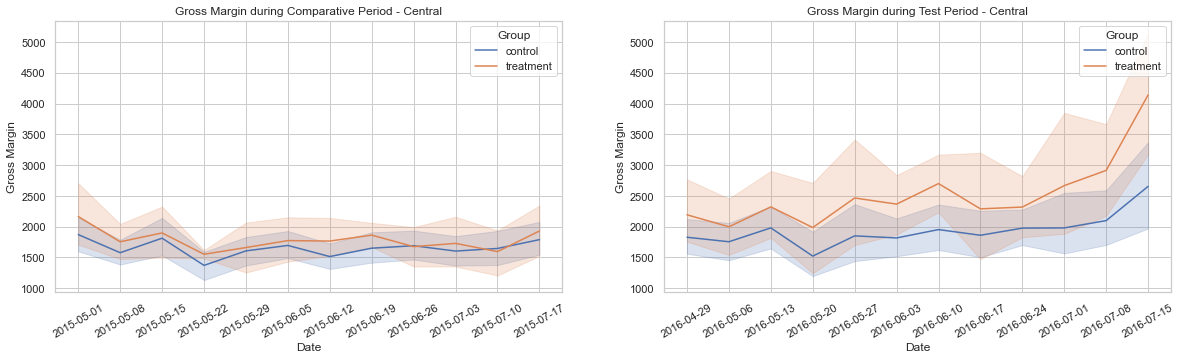

In [58]:
plt.figure(figsize =[20,5] )

plt.subplot(1,2,2)
ax2 = sns.lineplot(data = test_period_central, x = 'Week_Start', y="Gross_Margin", hue = 'Group')
ax2.set(xlabel='Date', ylabel='Gross Margin')
plt.xticks(rotation=30)
plt.title('Gross Margin during Test Period - Central')

plt.subplot(1,2,1, sharey = ax2)
ax1 = sns.lineplot(data = compartive_period_central, x = 'Week_Start', y="Gross_Margin", hue = 'Group')
ax1.set(xlabel='Date', ylabel='Gross Margin')
plt.xticks(rotation=30)
plt.title('Gross Margin during Comparative Period - Central')

#### T-Test (Central)

In [59]:
test_period_central.groupby('Group')['Gross_Margin'].mean()

Group
control      1939.705253
treatment    2529.842308
Name: Gross_Margin, dtype: float64

Text(0, 0.5, 'Average Gross Margin')

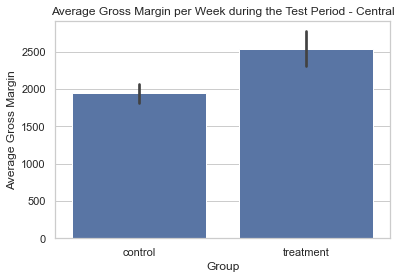

In [60]:
base_color = sns.color_palette()[0]
sns.barplot(data = test_period_central, x = 'Group', y = 'Gross_Margin', color = base_color)
plt.title('Average Gross Margin per Week during the Test Period - Central')
plt.ylabel('Average Gross Margin')

In [61]:
# T-test for "Average Gross Margin - Central"
from scipy import stats
stats.ttest_ind(test_period_central.query('Group == "control"')['Gross_Margin'] , test_period_central.query('Group == "treatment"')['Gross_Margin'] , equal_var = False)

Ttest_indResult(statistic=-4.072571513965795, pvalue=9.936362325813128e-05)

### West

In [62]:
west_stores = [2288, 2293, 2301, 2322, 2341, 2568, 8817, 12286, 9524, 11668, 12169, 10218, 9388, 9188, 9524 ]
data_merged_west = data_merged[data_merged.StoreID.isin(west_stores)]

In [63]:
compartive_period_west = data_merged_west.query('Week > 12 & Week < 25')
test_period_west = data_merged_west.query('Week >64 & Week < 77')

#### Time Comparison Plot (West)

Text(0.5, 1.0, 'Gross Margin during Comparative Period - West')

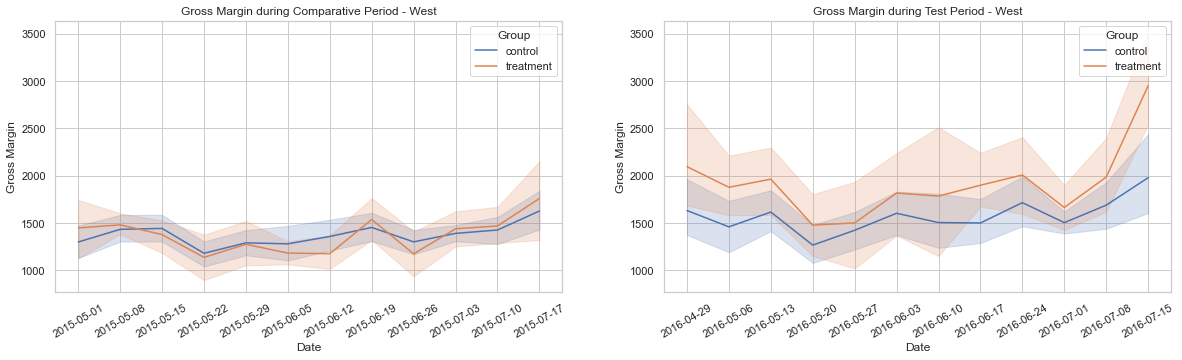

In [64]:
plt.figure(figsize =[20,5] )

plt.subplot(1,2,2)
ax2 = sns.lineplot(data = test_period_west, x = 'Week_Start', y="Gross_Margin", hue = 'Group')
ax2.set(xlabel='Date', ylabel='Gross Margin')
plt.xticks(rotation=30)
plt.title('Gross Margin during Test Period - West')


plt.subplot(1,2,1, sharey = ax2)
ax1 = sns.lineplot(data = compartive_period_west, x = 'Week_Start', y="Gross_Margin", hue = 'Group')
ax1.set(xlabel='Date', ylabel='Gross Margin')
plt.xticks(rotation=30)
plt.title('Gross Margin during Comparative Period - West')

####  T - test (West)

In [65]:
test_period_west.groupby('Group')['Gross_Margin'].mean()

Group
control      1573.117348
treatment    1917.599400
Name: Gross_Margin, dtype: float64

Text(0, 0.5, 'Average Gross Margin')

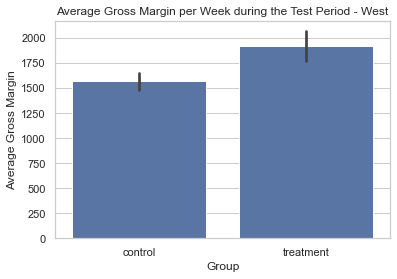

In [66]:
sns.barplot(data = test_period_west, x = 'Group', y = 'Gross_Margin', color = base_color)
plt.title('Average Gross Margin per Week during the Test Period - West')
plt.ylabel('Average Gross Margin')

In [67]:
# T-test for "Average Gross Margin - West"
from scipy import stats
stats.ttest_ind(test_period_west.query('Group == "control"')['Gross_Margin'] , test_period_west.query('Group == "treatment"')['Gross_Margin'] , equal_var = False)

Ttest_indResult(statistic=-3.870869402972576, pvalue=0.00020225306382460874)

### Overall (Central + West)

In [68]:
data_merged_overall = data_merged[data_merged.StoreID.isin(west_stores)| data_merged.StoreID.isin(central_stores)]
compartive_period_overall = data_merged_overall.query('Week > 12 & Week < 25')
test_period_overall= data_merged_overall.query('Week >64 & Week < 77')

Text(0.5, 1.0, 'Gross Margin during Comparative Period - Overall')

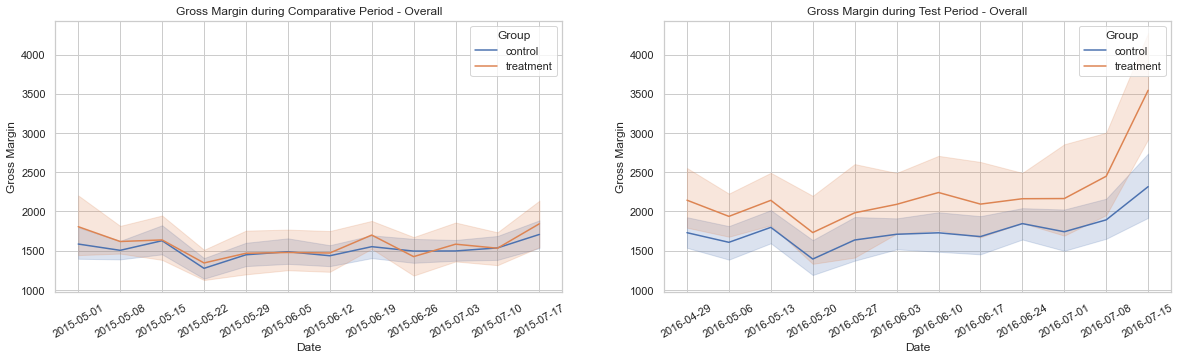

In [69]:
plt.figure(figsize =[20,5] )

plt.subplot(1,2,2)
ax2 = sns.lineplot(data = test_period_overall, x = 'Week_Start', y="Gross_Margin", hue = 'Group')
ax2.set(xlabel='Date', ylabel='Gross Margin')
plt.xticks(rotation=30)
plt.title('Gross Margin during Test Period - Overall')


plt.subplot(1,2,1, sharey = ax2)
ax1 = sns.lineplot(data = compartive_period_overall, x = 'Week_Start', y="Gross_Margin", hue = 'Group')
ax1.set(xlabel='Date', ylabel='Gross Margin')
plt.xticks(rotation=30)
plt.title('Gross Margin during Comparative Period - Overall')

####  T - test (Central + West)

In [70]:
test_period_overall.groupby('Group')['Gross_Margin'].mean()

Group
control      1756.411301
treatment    2223.720854
Name: Gross_Margin, dtype: float64

Text(0, 0.5, 'Average Gross Margin')

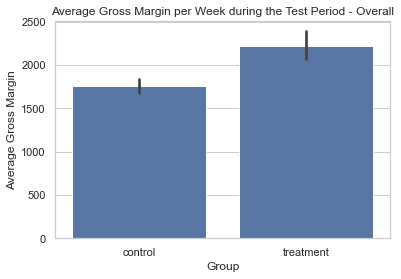

In [71]:
sns.barplot(data = test_period_overall, x = 'Group', y = 'Gross_Margin', color = base_color)
plt.title('Average Gross Margin per Week during the Test Period - Overall')
plt.ylabel('Average Gross Margin')

In [72]:
stats.ttest_ind(test_period_overall.query('Group == "control"')['Gross_Margin'] , test_period_overall.query('Group == "treatment"')['Gross_Margin'] , equal_var = False)

Ttest_indResult(statistic=-5.203786969045747, pvalue=5.286829028678395e-07)

## Conclusion

> According to the A/B Test Comparisons, the gross margin of the treatment stores in Central and West regions showed 30.42% and 21.9% growth at a significance level of 99.99% and 99.98% over the control stores, respectively. The expected impact of gross margin per week from Central region is USD 590.13, higher than that from West: USD 344.5. In both regions, the time comparison plots apparently show the improved sales trend after the implementation of the test. The treatment and control units have roughly similar sales during the comparative period on the left, but after the experiment began, there was a considerable increase in the profits of the treatment stores.
The overall average lift as a result from launching the updated offerings would be 26.61% per store per week, approximately USD 467.309 increasing per unit per week. Introducing the new menu would improve the weekly gross margin, higher than 18% which is the cut-off that the management suggested, thus the company should roll out the new menu to all stores.